# Simulated-based-inference of 6D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

#from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi
#from sbi.utils.get_nn_models import posterior_nn

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [6]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [7]:
Res_dir='Res_Epileptor6D_sde_sbi'

### Simulator

In [8]:
def Epileptor6Dmodel(params, constants, dt, ts):
   
    eta = params[0]
    tau1=params[1]
    eta.astype(float)
    tau1.astype(float)

    # fixed parameters
    tau2, I1, I2, gamma=constants[0], constants[1], constants[2], constants[3]
    
    x1th=0;
    x2th=-0.25;

    nt=ts.shape[0]
    dt = np.float(dt)    
    
    # simulation from initial point
    x1, y1, z, x2, y2, u= np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    F1, F2, h =np.zeros(nt), np.zeros(nt), np.zeros(nt)
    
    states=np.zeros((2*nt))
    
    x1_init, y1_init, z_init, x2_init, y2_init, u_init= -2.0, -18.0, 4.0, 0., 0., 0.

    x1[0] = np.float(x1_init) 
    y1[0] = np.float(y1_init) 
    z[0] = np.float(z_init) 
    x2[0] = np.float(x2_init) 
    y2[0] = np.float(y2_init) 
    u[0] = np.float(u_init) 

    sigma1, sigma, sigma2=0., 0., 0.
    
    for i in range(1, nt):
        if x1[i-1]<0:
              F1[i-1]=(x1[i-1]**3)-3*(x1[i-1]**2);
        else:
              F1[i-1]=(x2[i-1]-(0.6*((z[i-1]-4)**2)))*x1[i-1];

        if x2[i-1]<-0.25:
              F2[i-1]=0
        else:
              F2[i-1]=6*(x2[i-1]+0.25)*x1[i-1];

        h[i-1]=4*(x1[i-1]-eta)
        #h=(eta+3.0)/(1+exp((-x1-0.5)/0.1));    

        dx1=(y1[i-1]-F1[i-1]-z[i-1]+I1)
        dy1=(1.-(5*x1[i-1]**2)-y1[i-1])
        dz=(1/tau1)*(h[i-1]-z[i-1]);
        dx2=(-y2[i-1]+x2[i-1]-(x2[i-1]**3)+I2+(2*u[i-1])-0.3*(z[i-1]-3.5));
        dy2=(1/tau2)*(-y2[i-1]+F2[i-1]);
        du=(-gamma*(u[i-1]-0.1*x1[i-1]));
        
    
        x1[i]=x1[i-1] + dt * dx1 +  np.sqrt(dt)*sigma1*np.random.randn()
        y1[i]=y1[i-1] + dt * dy1 +  np.sqrt(dt)*sigma1*np.random.randn()
        z[i]=z[i-1] + dt * dz +  np.sqrt(dt)*sigma*np.random.randn()
        x2[i]=x2[i-1] + dt * dx2 +  np.sqrt(dt)*sigma2*np.random.randn()
        y2[i]=y2[i-1] + dt * dy2 +  np.sqrt(dt)*sigma2*np.random.randn()
        
    

    states=  np.concatenate((np.array(x1).reshape(-1), np.array(z).reshape(-1)))   
    
    return states
     

In [9]:
Epileptor6Dmodel = numba.jit(Epileptor6Dmodel)

### sanity check simulations

In [10]:
T = 4000.0
dt=0.01
ts = np.arange(0, T + dt, dt)
nt=ts.shape[0]

In [11]:
tau2=10.
I1=3.1
I2=0.45
gamma=.01

constants = np.array([ tau2, I1, I2, gamma])

In [12]:
# three sets of params (eta)
params = np.array([[-2.5, 2857.0],[-2., 2857.0],[-1.5, 2857.0]])
params.shape

(3, 2)

In [13]:
num_p = len(params[:,0])
sim_p_x = np.zeros((num_p, nt))
num_p,sim_p_x.shape

(3, (3, 400001))

In [14]:
start_time = time.time()
i=0
_ = Epileptor6Dmodel(params[i,:], constants, dt, ts)
print(" single sim takes (sec):" , (time.time() - start_time))

 single sim takes (sec): 1.8277101516723633


In [15]:
start_time = time.time()
i=0
_ = Epileptor6Dmodel(params[i,:], constants, dt, ts)
print(" single sim with numba takes (sec):" , (time.time() - start_time))

 single sim with numba takes (sec): 0.11054754257202148


In [16]:
start_time = time.time()

for i in range(num_p):
    sim_p_x[i,:] = Epileptor6Dmodel(params[i,:], constants, dt, ts)[0:nt]
    
print("similations with numba takes (sec):" , (time.time() - start_time))    

similations with numba takes (sec): 0.31380343437194824


/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


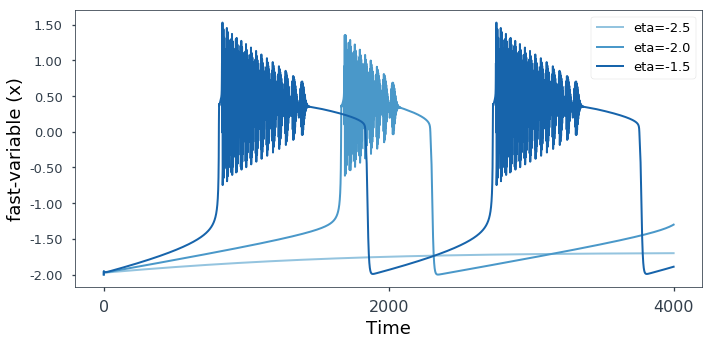

In [17]:
col_min = 2
num_colors = num_p+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


fig = plt.figure(figsize=(10,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_p):
    plt.plot(ts,sim_p_x[i,:],color=col1[i], lw=2, label='eta='+str(params[i,0]))

plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.legend(loc='upper right')
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_xticks([0, max(ts)/2, max(ts)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.tight_layout();
plt.show()

In [18]:
def Epileptor6Dmodel_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 4000.0
    dt=0.01
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau2=10.
    I1=3.1
    I2=0.45
    gamma=.01

    constants = np.array([tau2, I1, I2, gamma])
    
    nt=ts.shape[0]
    

    states = Epileptor6Dmodel(params, constants, dt, ts)
    return states.reshape(-1)  

## 3. Prior over model parameters

In [19]:
prior_min = [-5.0, 2800.]
prior_max = [0.0, 3000.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [20]:
start_time = time.time()

posterior = infer(Epileptor6Dmodel_simulator_wrapper, prior, method='SNPE', num_simulations=1000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget

Neural network successfully converged after 155 epochs.

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))



------------------------------------------------------------
--- 3279.272575855255 seconds ---


### EZ

In [38]:
# true parameters and respective labels
labels_params = [r'$\eta$', r'$\tau$']

In [39]:
true_params = np.array([-1.6, 2857.0])

In [23]:
y_obs=Epileptor6Dmodel(true_params, constants, dt, ts)#+sigma*randn(2*ts.shape[0])

In [24]:
y_obs.shape

(800002,)

In [25]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


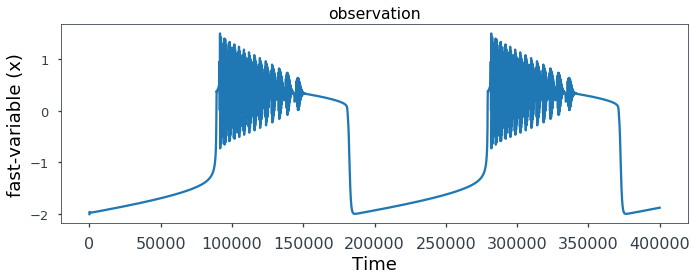

In [26]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.eps"), dpi=800)
plt.show()

### Posterior EZ

In [33]:
num_samples=1000

In [34]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [35]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_ez_posterior_samples.npy') , posterior_samples)

In [36]:
num_params=posterior_samples.shape[1]

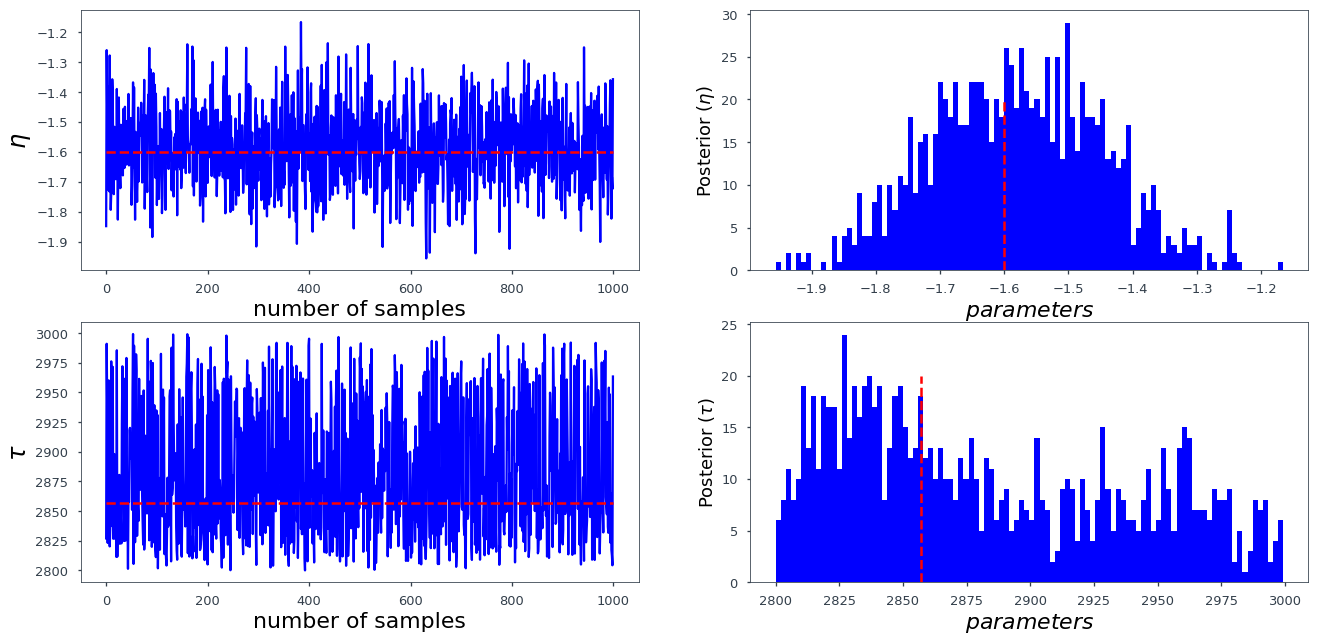

In [41]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=20, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.eps"), dpi=800)   
plt.show()

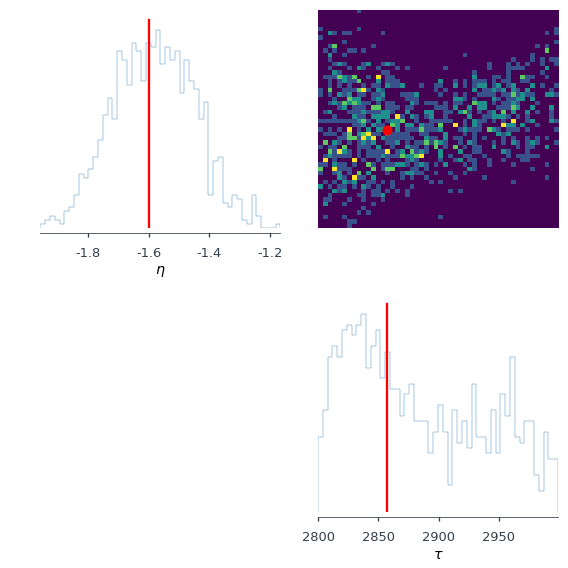

In [42]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.eps"), dpi=800) 
plt.show()

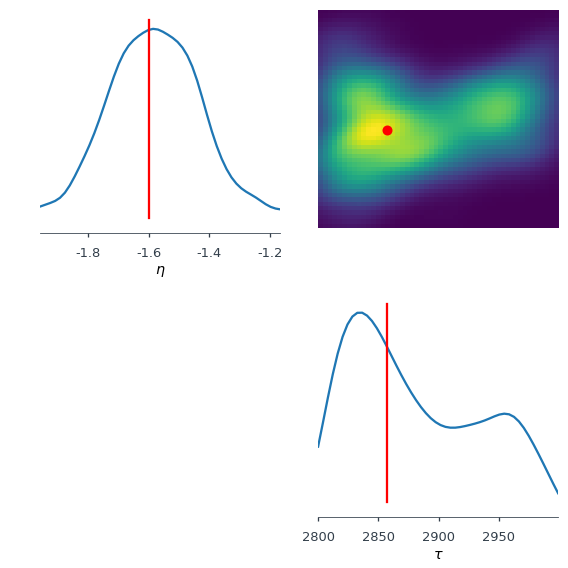

In [43]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.eps"), dpi=800)
plt.show()

In [44]:
y_fit=Epileptor6Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, dt, ts)

In [45]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [46]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_ez_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_ez_y_fit.npy') , y_fit)

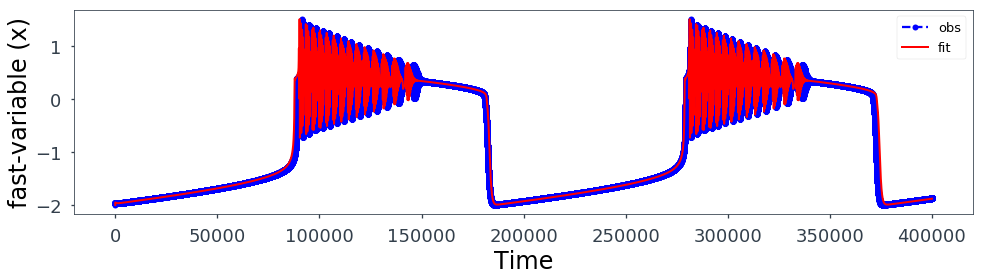

In [48]:
plt.figure(figsize=(14,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.eps"), dpi=800)  
plt.show()

### PZ

In [55]:
true_params = np.array([-2., 2857.0])

In [56]:
y_obs=Epileptor6Dmodel(true_params, constants, dt, ts)#+sigma*randn(2*ts.shape[0])

In [57]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

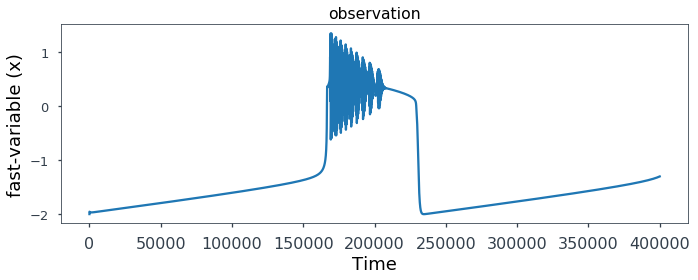

In [58]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.eps"), dpi=800)
plt.show()

### Posterior PZ

In [59]:
num_samples=1000

In [60]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [61]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_pz_posterior_samples.npy') , posterior_samples)

In [62]:
num_params=posterior_samples.shape[1]

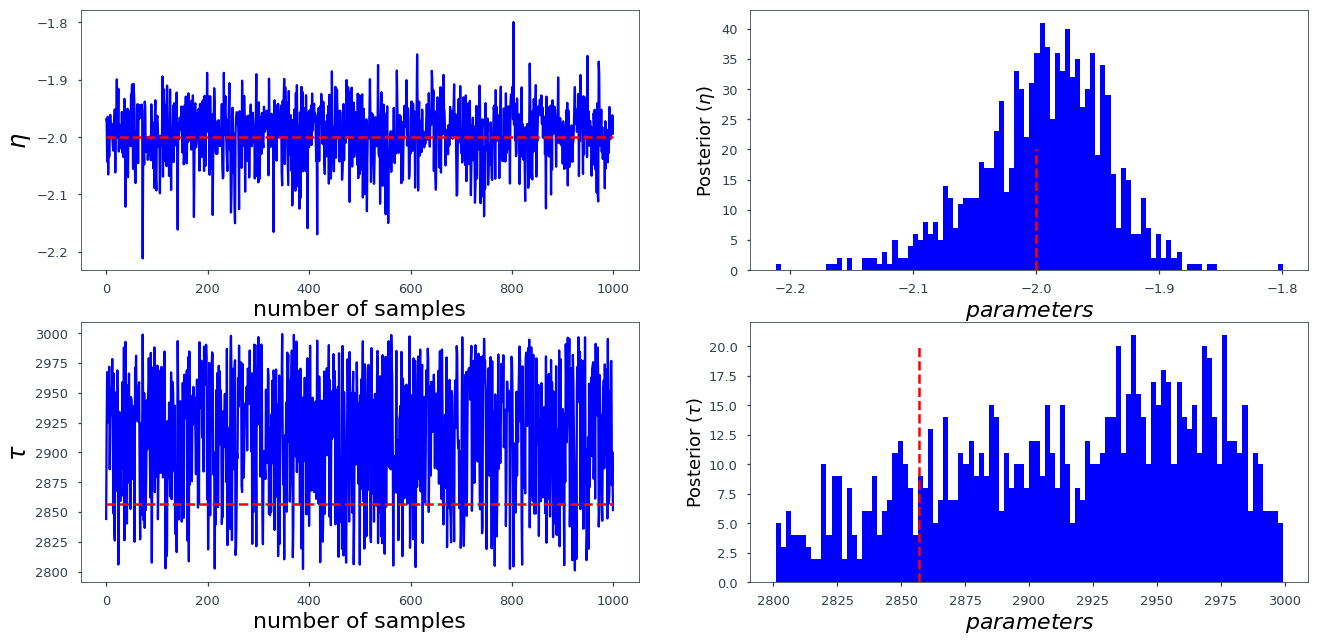

In [63]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=20, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.eps"), dpi=800)     
plt.show()

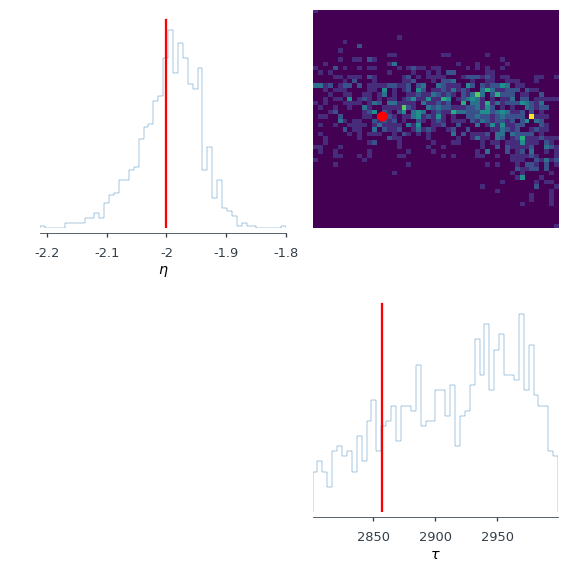

In [64]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.eps"), dpi=800) 
plt.show()

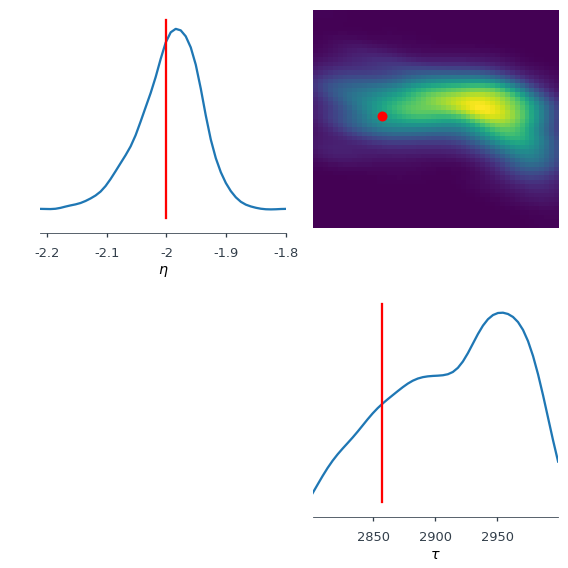

In [65]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.eps"), dpi=800)  
plt.show()

In [67]:
y_fit=Epileptor6Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, dt, ts)

In [68]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [69]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_pz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_pz_y_fit.npy') , y_fit)

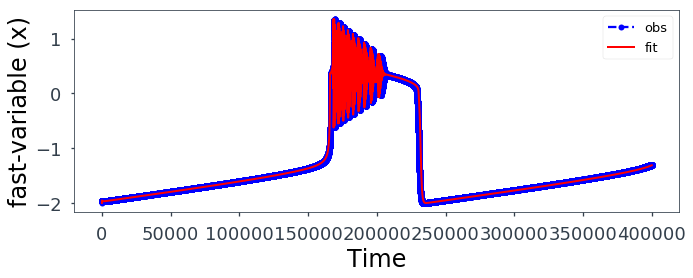

In [70]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.eps"), dpi=800)
plt.show()

### HZ

In [72]:
true_params = np.array([-2.5, 2857.0])

In [74]:
y_obs=Epileptor6Dmodel(true_params, constants, dt, ts)#+sigma*randn(2*ts.shape[0])

In [75]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

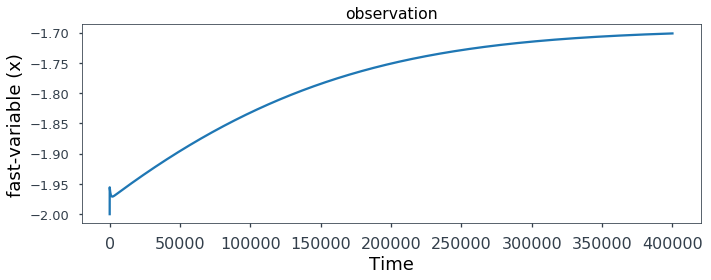

In [76]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.eps"), dpi=800)
plt.show()

### Posterior HZ

In [77]:
num_samples=1000

In [78]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [79]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_obs3_posterior_samples.npy') , posterior_samples)

In [80]:
num_params=posterior_samples.shape[1]

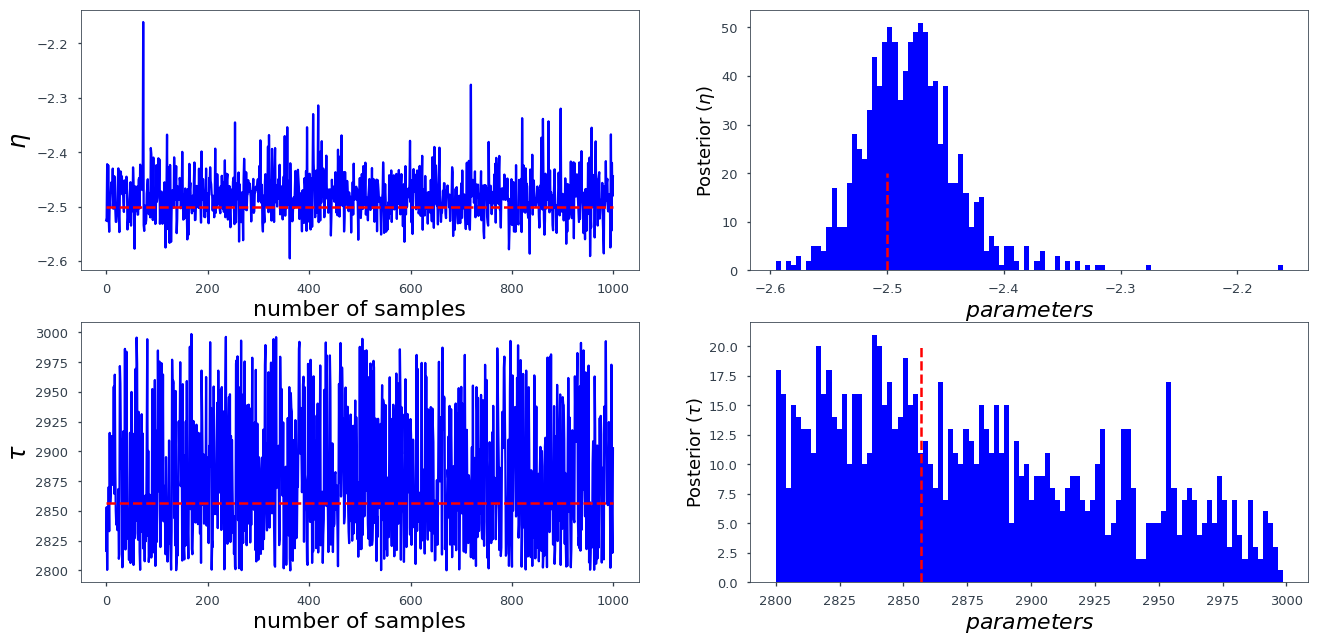

In [81]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=20, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.eps"), dpi=800)    
plt.show()

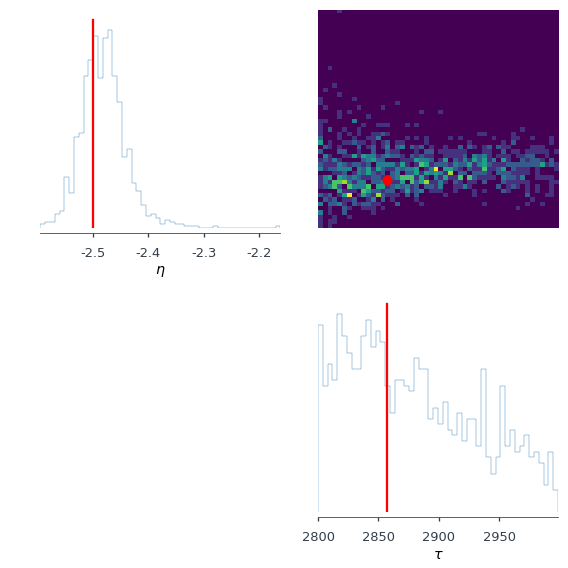

In [82]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.eps"), dpi=800)  
plt.show()

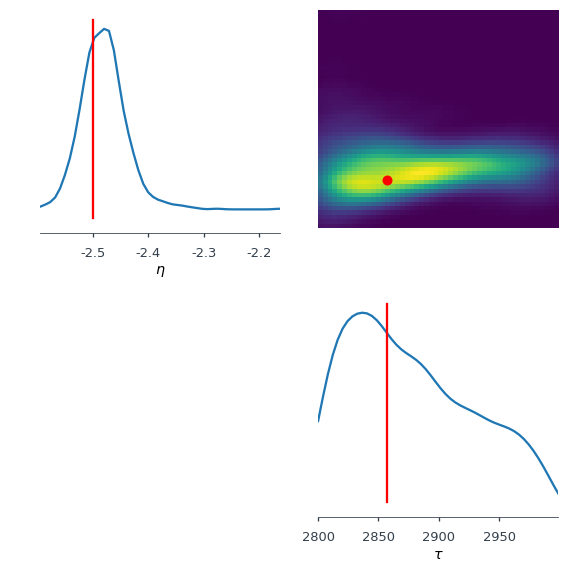

In [83]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.eps"), dpi=800)
plt.show()

In [85]:
y_fit=Epileptor6Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, dt, ts)

In [86]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [87]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_hz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor6D_sde_sbi_hz_y_fit.npy') , y_fit)

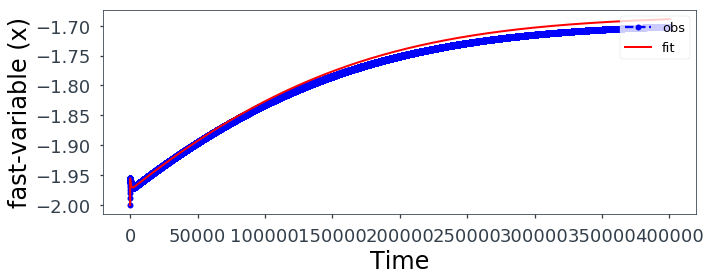

In [88]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.eps"), dpi=800) 
plt.show()